In [1]:
import sys
sys.path.append('/Automatic-Circuit-Discovery/')
sys.path.append('..')
import os
import re
import json
import pandas as pd
import torch as t
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-v0_8-paper')
pd.options.display.max_colwidth = 100

from acdc.docstring.utils import get_docstring_subgraph_true_edges

device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

/Users/canrager/.pyenv/versions/acdc_env/envs/acdcpp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


# Load experiment and results

In [2]:
EXP_NAME = 'docstring_abs_youdens_peak'
with open(f'./res/{EXP_NAME}/present_edge_attrs.json', 'r') as f:
    present_edge_attrs = json.load(f)

with open(f'./res/{EXP_NAME}/num_passes.json', 'r') as f:
    num_passes = json.load(f)

In [3]:
from acdc.docstring.utils import get_all_docstring_things
from acdc.TLACDCExperiment import TLACDCExperiment
all_docstring_items = get_all_docstring_things(num_examples=40, seq_len=5, device=device, metric_name='docstring_metric', correct_incorrect_wandb=False)

model = all_docstring_items.tl_model
test_metrics = all_docstring_items.test_metrics['docstring_metric']
test_data = all_docstring_items.test_data
test_patch_data = all_docstring_items.test_patch_data

exp = TLACDCExperiment(
            model=model,
            threshold=0,
            ds=test_data,
            ref_ds=test_patch_data,
            metric=test_metrics,
            run_name=None,
        )
exp.model.reset_hooks()
exp.setup_model_hooks(
    add_sender_hooks=True,
    add_receiver_hooks=True,
    doing_acdc_runs=False
)

del all_docstring_items

Loaded pretrained model attn-only-4l into HookedTransformer
Moving model to device:  cpu


self.current_node=TLACDCInterpNode(blocks.3.hook_resid_post, [:])


# All edges and ground truth eges

In [4]:
def convert_to_torch_index(index_list):
    return ''.join(['None' if i == ':' else i for i in index_list])

def get_all_edges(exp):
    all_edges = set()
    for child_name in exp.corr.edges:
        for child_idx in exp.corr.edges[child_name]:
            child_idx_converted = convert_to_torch_index(str(child_idx))
            for parent_name in exp.corr.edges[child_name][child_idx]:
                for parent_idx in exp.corr.edges[child_name][child_idx][parent_name]:
                    parent_idx_converted = convert_to_torch_index(str(parent_idx))
                    all_edges.add(f'{parent_name}{parent_idx_converted}{child_name}{child_idx_converted}')
    return all_edges

all_edges = get_all_edges(exp)

In [5]:
# EDGES ground truth
true_edges_tuples = get_docstring_subgraph_true_edges()
true_edges = set()
replace_parens = lambda tup: str(tup).replace('(', '[').replace(')', ']').replace('[None,]', '[None]')

for child_name, child_idx, parent_name, parent_idx in true_edges_tuples:
    true_edges.add(f'{parent_name}{replace_parens(parent_idx)}{child_name}{replace_parens(child_idx)}')

In [6]:
# pruned_edges, true_edges should all be in all_edges
def test_all_edges(pruned_edges, verbose=False):
    for pruned_edge in pruned_edges:
        if not pruned_edge in all_edges:
            print(pruned_edge)
    if verbose:
        print('Pruned edge test complete')
    for true_edge in true_edges:
        if not true_edge in all_edges:
            print(true_edge)
    if verbose:
        print('True edge test complete')

In [7]:
data = []
for pp_thresh in present_edge_attrs.keys():
    for acdc_thresh in present_edge_attrs[pp_thresh].keys():
        # Read set of present edges after applying AP and ACDC
        present_edges = set()
        for (child_name, child_idx, parent_name, parent_idx, attr) in present_edge_attrs[pp_thresh][acdc_thresh]: # sorry, messed up parent child indexing convention
            present_edges.add(f'{parent_name}{replace_parens(parent_idx)}{child_name}{replace_parens(child_idx)}')
            # present_edges.add(f'{parent_name}{parent_idx}{child_name}{child_idx}')
        test_all_edges(present_edges)

        # Calc stats
        tp = len(present_edges.intersection(true_edges))
        tn = len((all_edges - present_edges).intersection(all_edges - true_edges))
        fp = len(present_edges - true_edges)
        fn = len(true_edges - present_edges)

        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        fpr = 1 - tnr
        fnr = 1 - tpr

        pp_thr = np.round(float(pp_thresh), 4)
        acdc_thr = np.round(float(acdc_thresh), 4)
        pp_thr_str = pp_thresh[:6]
        acdc_thr_str = acdc_thresh[:6]
        ap_youdens = np.round(tpr-fpr, 2)
        passes = num_passes[pp_thresh][acdc_thresh]

        data.append([pp_thr, acdc_thr, pp_thr_str, acdc_thr_str, tpr, tnr, fpr, fnr, ap_youdens, passes])

df = pd.DataFrame(data, columns=['pp_thresh', 'acdc_thresh', 'pp_thresh_str', 'acdc_thresh_str', 'tpr', 'tnr', 'fpr', 'fnr', 'youdens', 'num_passes'])
df

,pp_thresh,acdc_thresh,pp_thresh_str,acdc_thresh_str,tpr,tnr,fpr,fnr,youdens,num_passes
0,0.0340,0.060,0.034,0.06,0.648649,0.979805,0.020195,0.351351,0.63,112
1,0.0340,0.095,0.034,0.095,0.621622,0.990251,0.009749,0.378378,0.61,96
2,0.0340,0.130,0.034,0.13,0.486486,0.997214,0.002786,0.513514,0.48,80
3,0.0340,0.165,0.034,0.165,0.297297,1.000000,0.000000,0.702703,0.30,55
4,0.0340,0.200,0.034,0.2,0.297297,1.000000,0.000000,0.702703,0.30,55
5,0.0398,0.060,0.0397,0.06,0.891892,0.979805,0.020195,0.108108,0.87,120
6,0.0398,0.095,0.0397,0.095,0.864865,0.989554,0.010446,0.135135,0.85,108
7,0.0398,0.130,0.0397,0.13,0.783784,0.990947,0.009053,0.216216,0.77,98
8,0.0398,0.165,0.0397,0.165,0.702703,0.995125,0.004875,0.297297,0.70,83
9,0.0398,0.200,0.0397,0.2,0.594595,0.996518,0.003482,0.405405,0.59,70


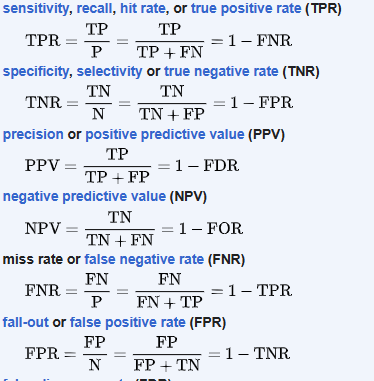

# Youdens J metric (TPR - FPR)

In [8]:
ydf = df.pivot(index='acdc_thresh_str', columns='pp_thresh_str')['youdens']

In [9]:
fig = px.imshow(
    ydf,
    text_auto=True,
    color_continuous_scale="RdBu",
    labels=dict(x="Attribution Patching threshold", y="ACDC threshold"),
    )

fig.update_xaxes(tickangle = 45)
fig.update_yaxes(ticksuffix = '  ')
fig.show()

# Num passes vs Youdens metric

In [10]:
df["pp_thresh_between_0.04_0.07"] = (df["pp_thresh"] > 0.04) & (df["pp_thresh"] < 0.07)
ndf = df[["num_passes", "youdens", "pp_thresh_between_0.04_0.07", "pp_thresh"]].sort_values("num_passes")
ndf

,num_passes,youdens,pp_thresh_between_0.04_0.07,pp_thresh
49,45,0.59,False,0.0860
44,46,0.59,False,0.0802
48,52,0.64,False,0.0860
42,53,0.64,False,0.0802
43,53,0.61,False,0.0802
39,54,0.59,False,0.0744
3,55,0.30,False,0.0340
4,55,0.30,False,0.0340
34,56,0.59,True,0.0687
47,56,0.70,False,0.0860


In [11]:
px.scatter(ndf, x="num_passes", y="youdens", color="pp_thresh_between_0.04_0.07")

## Reference values

### Find pareto optimal youdens val for AP only

In [12]:
with open(f'./res/{EXP_NAME}/acdcpp_only_attrs.json', 'r') as f:
    ap_only_attrs = np.array(json.load(f))

edges = np.array(["".join(i[:4]) for i in ap_only_attrs])
is_ground_truth = [edge in true_edges for edge in edges]
attrs = np.array(ap_only_attrs[:,4], dtype=np.float64)
apdf = pd.DataFrame(dict(attrs=attrs, edges=edges, is_ground_truth=is_ground_truth))

In [13]:
ap_threshs = attrs.copy()
num_steps = len(attrs)
ap_youdens = np.zeros(num_steps)
ap_tpr = np.zeros(num_steps)
ap_fpr = np.zeros(num_steps)

for i, thr in enumerate(ap_threshs):
    p_edges = set(edges[(attrs > thr)])
    # Calc stats
    tp = len(p_edges.intersection(true_edges))
    tn = len((all_edges - p_edges).intersection(all_edges - true_edges))
    fp = len(p_edges - true_edges)
    fn = len(true_edges - p_edges)

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = 1 - tnr
    fnr = 1 - tpr

    ap_youdens[i] = tpr - fpr
    ap_tpr[i] = tpr
    ap_fpr[i] = fpr


ap_tpr_srt = np.sort(ap_tpr)
ap_fpr_srt = np.sort(ap_fpr)
ap_youdens_sorted = ap_tpr_srt - ap_fpr_srt
print("pareto optimal youdens val for AP only:\n", max(ap_youdens_sorted))

pareto optimal youdens val for AP only:
 0.8860573665587593


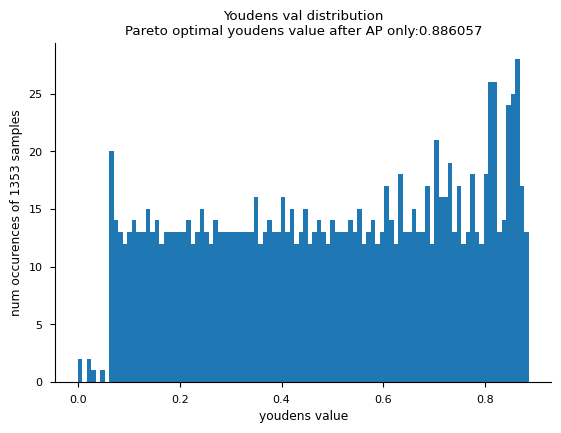

In [14]:
plt.hist(ap_youdens, bins=100)
plt.xlabel('youdens value')
plt.ylabel(f'num occurences of {num_steps} samples')
plt.title(f"Youdens val distribution\nPareto optimal youdens value after AP only:{max(ap_youdens):5f}");

### Find pareto optimal youdens in ACDC results

In [15]:
with open(f'../Automatic-Circuit-Discovery/experiments/results/plots_data/acdc-docstring-kl_div-False-0.json', 'r') as f:
    acdc_stats_raw = json.load(f)

Text(0.5, 1.0, 'Pareto optimal youdens val\nACDC (kl_div):0.142921\nAP (docstring metric): 0.886057')

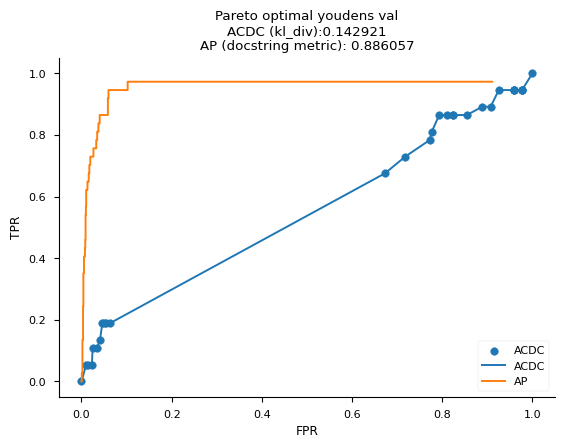

In [16]:
acdc_stats = acdc_stats_raw['trained']['random_ablation']['docstring']['kl_div']['ACDC']

acdc_tpr = np.array(acdc_stats['edge_tpr'])
acdc_fpr = np.array(acdc_stats['edge_fpr'])
acdc_tpr = np.sort(acdc_tpr)
acdc_fpr = np.sort(acdc_fpr)
acdc_youdens = acdc_tpr - acdc_fpr

plt.scatter(acdc_fpr, acdc_tpr, label="ACDC")
plt.plot(acdc_fpr, acdc_tpr, label="ACDC")
plt.plot(ap_fpr_srt, ap_tpr_srt, label="AP")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.title(f'Pareto optimal youdens val\nACDC (kl_div):{max(acdc_youdens):5f}\nAP (docstring metric): {max(ap_youdens):5f}')

### Add scatter points for fpr, tpr changing AP thresh with fixed AP thresh

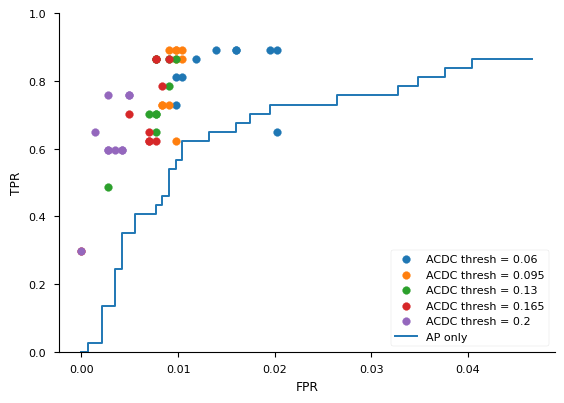

In [17]:
acdc_threshs = df.acdc_thresh.unique()
for acdc_t in acdc_threshs:
    roc_df = df[df.acdc_thresh == acdc_t]
    # ROC add youdens
    plt.scatter(roc_df.fpr, roc_df.tpr, label=f'ACDC thresh = {acdc_t}')


cutoff = 100
plt.plot(ap_fpr_srt[:cutoff], ap_tpr_srt[:cutoff], label="AP only")
#plt.plot(ap_fpr_srt, ap_tpr_srt, label="AP only")
plt.legend()
plt.xlabel('FPR')
plt.ylim((0,1))
plt.ylabel('TPR')
#plt.title("ROC for combined methods EAP + ACDC")
plt.savefig('combined ROC inset.png', dpi=200)

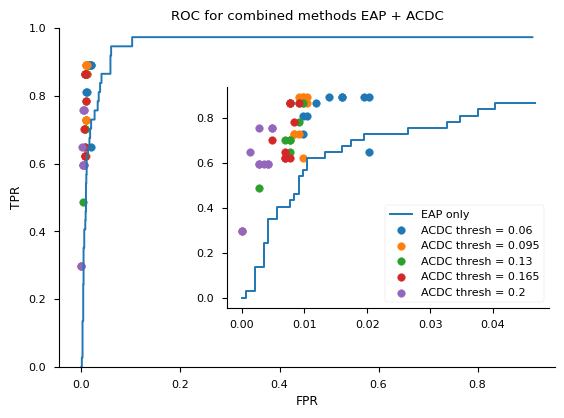

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create the main plot
fig, ax = plt.subplots()


ax.plot(ap_fpr_srt, ap_tpr_srt, label="EAP only")


# Create the inset plot
axins = inset_axes(ax, width='65%', height='65%', loc='center right')
cutoff = 100
axins.plot(ap_fpr_srt[:cutoff], ap_tpr_srt[:cutoff], label="EAP only")
#axins.set_xlim(0, 0.5)  # Adjust the x-axis limits for the zoomed-in inset
#axins.set_ylim(0.8, 1)   # Adjust the y-axis limits for the zoomed-in inset


acdc_threshs = df.acdc_thresh.unique()
for acdc_t in acdc_threshs:
    roc_df = df[df.acdc_thresh == acdc_t]
    # ROC add youdens
    ax.scatter(roc_df.fpr, roc_df.tpr, label=f'ACDC thresh = {acdc_t}')
    axins.scatter(roc_df.fpr, roc_df.tpr, label=f'ACDC thresh = {acdc_t}')

axins.legend()
axins.spines['bottom'].set_color('black')  # Set the bottom spine (frame) color to black
axins.spines['top'].set_color('black')     # Set the top spine (frame) color to black
axins.spines['left'].set_color('black')    # Set the left spine (frame) color to black
axins.spines['right'].set_color('black')  

ax.set_xlabel('FPR')
ax.set_ylim((0, 1))
ax.set_ylabel('TPR')
ax.set_title("ROC for combined methods EAP + ACDC")

plt.savefig('combined ROC inset.pdf', dpi=200)

Text(0.5, 1.0, 'ROC for combined methods EAP + ACDC')

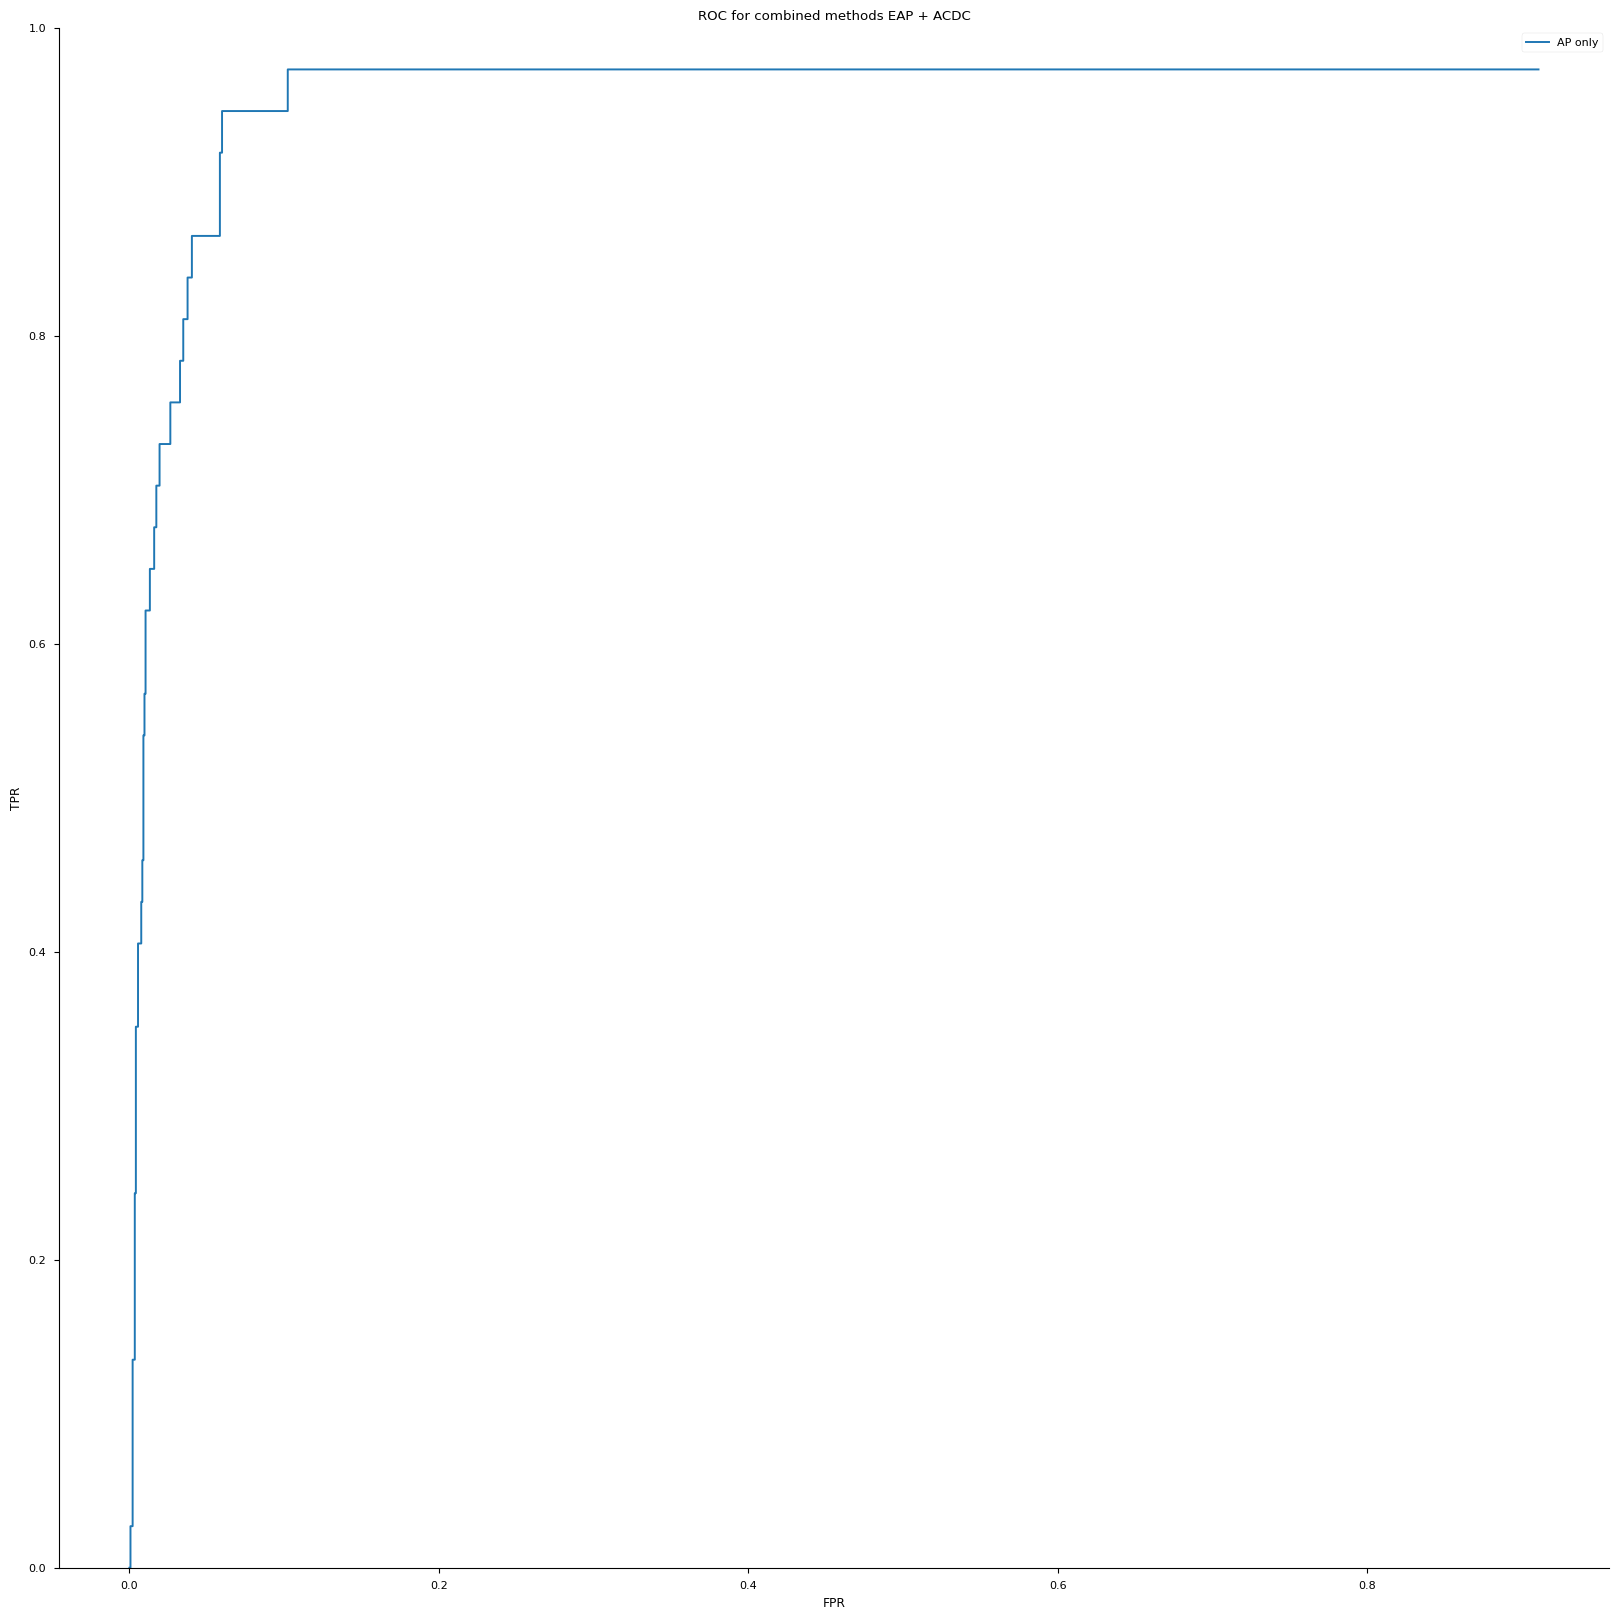

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

csv_data = [
[797.3266855, 9.518953577, 487.026819, 6.41595323],
[457.3328822, 9.408619701, 493.8012816, 6.352140859],
[321.4279994, 10.99152002, 505.8109589, 6.482765605],
[643.1595144, 11.33567151, 515.0500793, 5.689992589],
[897.9396964, 7.098272377, 523.5118663, 5.062645643],
[658.5927932, 8.401072532, 526.8570713, 5.951114622],
[885.8478465, 9.59502937, 537.6740407, 6.123622699],
[569.4313421, 5.913067314, 563.2567733, 6.089519297],
[419.540411 , 31.7279367, 569.4313421, 5.913067314]
]

data1 = pd.DataFrame(csv_data, columns=['x1',  'y1',   'xin',  'yin'])

fig = plt.figure(1,figsize=(20,20))

plt.subplot(111)
plt.plot(ap_fpr_srt, ap_tpr_srt, label="AP only")
plt.legend()
plt.xlabel('FPR')
plt.ylim((0,1))
plt.ylabel('TPR')
plt.title("ROC for combined methods EAP + ACDC")
# plt1 = zoomed_inset_axes(plt.gca(), 2.5)
# plt1.plot(data1['xin'], data1['yin']);

Text(0.5, 1.0, 'Pareto optimal youdens value after AP only:\n0.142921')

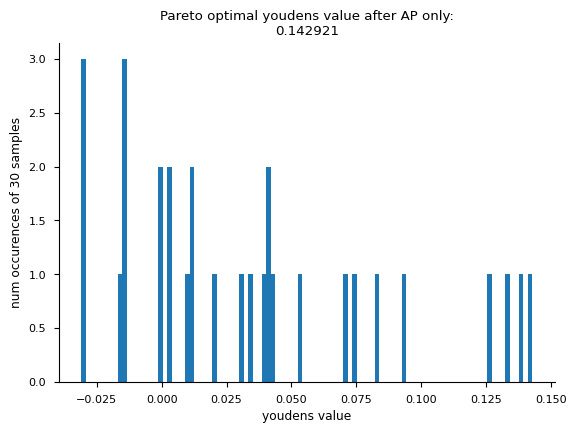

In [20]:
plt.hist(acdc_youdens, bins=100)
plt.xlabel('youdens value')
plt.ylabel(f'num occurences of {len(acdc_youdens)} samples')
plt.title(f"Pareto optimal youdens value after AP only:\n{max(acdc_youdens):5f}")

Text(0, 0.5, 'youdens val')

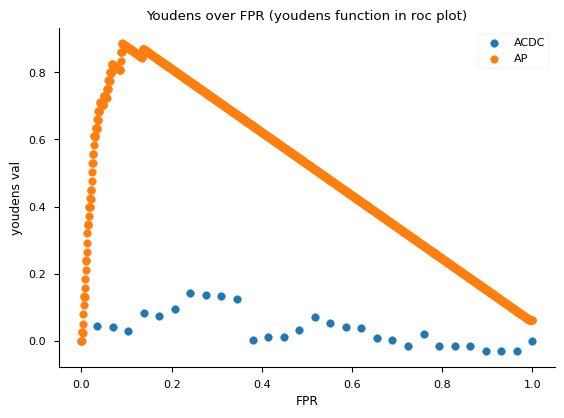

In [21]:
acdcsp = np.linspace(0, 1, len(acdc_youdens))
apsp = np.linspace(0,1, len(ap_youdens_sorted))
plt.scatter(acdcsp, acdc_youdens, label="ACDC")
plt.scatter(apsp, ap_youdens_sorted,label="AP")
plt.title("Youdens over FPR (youdens function in roc plot)")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("youdens val")

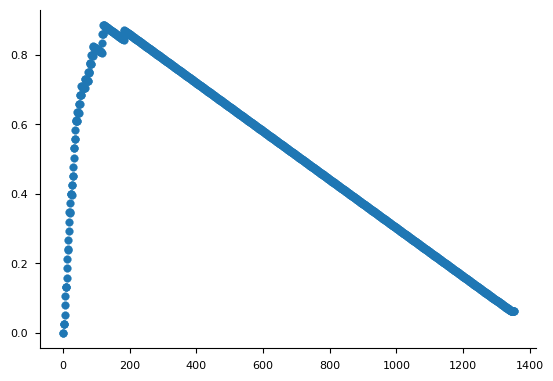

In [22]:
apsp = np.arange(len(ap_youdens_sorted))
plt.scatter(apsp, ap_youdens_sorted)

## [0.034, 0.0397] investigation

In [23]:
mask = (apdf["attrs"] > 0.034) & (apdf['attrs'] < 0.0397)
masked_apdf = apdf[mask].sort_values('attrs').reset_index(drop=True)
masked_apdf.head()

,attrs,edges,is_ground_truth
0,0.034035,"blocks.0.attn.hook_result[None, None, 5]blocks.2.hook_k_input[None, None, 3]",False
1,0.034045,"blocks.0.attn.hook_result[None, None, 1]blocks.2.hook_k_input[None, None, 0]",False
2,0.034085,"blocks.0.attn.hook_result[None, None, 6]blocks.2.hook_v_input[None, None, 5]",False
3,0.034320,"blocks.1.attn.hook_result[None, None, 2]blocks.3.hook_k_input[None, None, 7]",False
4,0.034497,"blocks.0.attn.hook_result[None, None, 5]blocks.3.hook_v_input[None, None, 7]",False


Text(0.5, 0, 'AP thresh')

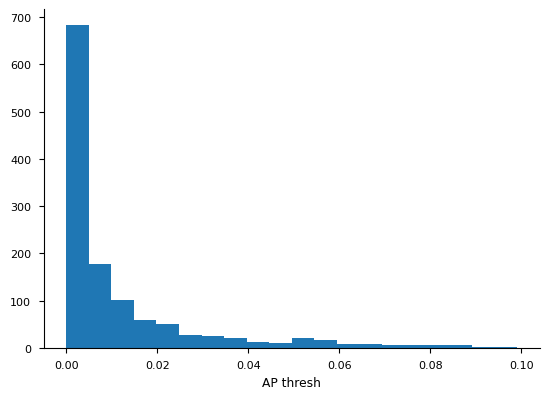

In [24]:
attrs_small = attrs[attrs<0.1]
plt.hist(attrs_small, bins=20)
plt.xlabel('AP thresh')

# ACDC num passes over Attribution Patching threshold

In [25]:
xlim = 0.1
fig = px.scatter(df[df["pp_thresh"] < xlim], x="pp_thresh", y="num_passes")
fig.update_xaxes(title="attribution patching threshold")